## Importing packages and functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
from cycler import cycler
import time

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
# database file can be downloaded at: https://www.kaggle.com/hugomathien/soccer
# Connecting to database
database = 'database.sqlite'
conn = sqlite3.connect(database)

# cursor = conn.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

#Fetching data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
conn.close()

## Defining functions needed for feature building

In [4]:
###### VECTORIZED CODE: 8.5 TIMES FASTER ###########
def find_previous(index, team, season, stage):
    """Determine previous match given season, stage, and team name
       Returns index and stage number of previous game played by team
       If no game is found it returns current index and stage"""
       
    tmp_stage = stage
    assigned = False
    # look for previous match, going back all the way to first game
    while (tmp_stage >= 2) & (not assigned):
        previous = betdf[(betdf['season']==season) & (betdf['stage']==tmp_stage-1) & ((betdf['home_team_api_id']==team) | (betdf['away_team_api_id']==team))]
        if previous.shape[0] == 1:
            previous_stage = previous['stage'].item()
            previous_index = previous.index[0]
            assigned = True
        else:
            tmp_stage -= 1
    
    # check if previous game was found, if not (went back to first game!) use current stage and index
    if not assigned:
        previous_stage = stage
        previous_index = index
    return previous_index, previous_stage      

    
def get_points(index, home, away, season, stage):
    """Given index, home and away teams, season, and stage, computes (and assigns to betdf) 
       average points up to previous game for both teams"""
    # recovering index number and stage of previous game
    previous_index_h, previous_stage_h = find_previous(index, home, season, stage)
    previous_index_a, previous_stage_a = find_previous(index, away, season, stage)

    # assigning avg_point for home team when a previous game was found
    if previous_stage_h != stage:
        # identifying field in previous game
        if betdf.loc[previous_index_h,'home_team_api_id'] == home:
            previous_field_h = 'home'
        else:
            previous_field_h = 'away'
        mydict = {'home':0, 'away':1}
        avg_points_h = ((stage-2)*betdf.loc[previous_index_h,'points_'+previous_field_h] + \
                      points_dict[betdf.loc[previous_index_h,'outcome']][mydict[previous_field_h]])/(stage-1)          
    # assigning points for home team when previous game was not found
    else:
        avg_points_h = 0.0
    # actual assignment to betdf
    betdf.loc[index,'points_home'] = avg_points_h
    
    # assigning avg_point for away team when a previous game was found
    if previous_stage_a != stage:
        # identifying field in previous game
        if betdf.loc[previous_index_a,'home_team_api_id'] == away:
            previous_field_a = 'home'
        else:
            previous_field_a = 'away'
        mydict = {'home':0, 'away':1}
        avg_points_a = ((stage-2)*betdf.loc[previous_index_a,'points_'+previous_field_a] + \
                      points_dict[betdf.loc[previous_index_a,'outcome']][mydict[previous_field_a]])/(stage-1)  
    # assigning points for away team when previous game was not found
    else:
        avg_points_a = 0.0
    # actual assignment to betdf
    betdf.loc[index,'points_away'] = avg_points_a
       


In [5]:
# vectorization of streak_feature
# it assigns streak values directly to betdf, without returning them

def get_streak(index,n):
    """Adds average points feature up to previous games to dataframe"""
    
    stage=betdf.loc[index,'stage']
    # computations for home team of 'current (index)' game
    tmp_stage = stage
    assigned = False
    while (tmp_stage-n>0) & (not assigned):
        subdf = betdf[(betdf['season']==betdf.loc[index,'season']) & (betdf['stage']==(tmp_stage-n)) & \
                ((betdf['home_team_api_id']==betdf.loc[index,'home_team_api_id']) | \
                 (betdf['away_team_api_id']==betdf.loc[index,'home_team_api_id']))]
        if subdf.shape[0] != 0:
            assigned = True
            if subdf.iloc[0]['home_team_api_id']==betdf.loc[index,'home_team_api_id']:
                betdf.loc[index,'streak_home'] = (betdf.loc[index,'points_home']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n  
            else:
                betdf.loc[index,'streak_home'] = (betdf.loc[index,'points_home']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
        else:
            tmp_stage -= 1

    # computations for away team of current (index) game
    tmp_stage = stage
    assigned = False
    while (tmp_stage-n>0) & (not assigned):
        subdf = betdf[(betdf['season']==betdf.loc[index,'season']) & (betdf['stage']==(tmp_stage-n)) & \
                ((betdf['home_team_api_id']==betdf.loc[index,'away_team_api_id']) | \
                 (betdf['away_team_api_id']==betdf.loc[index,'away_team_api_id']))]
        if subdf.shape[0] != 0:
            assigned = True
            if subdf.iloc[0]['home_team_api_id']==betdf.loc[index,'away_team_api_id']:
                betdf.loc[index,'streak_away'] = (betdf.loc[index,'points_away']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
            else:
                betdf.loc[index,'streak_away'] = (betdf.loc[index,'points_away']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
        else:
            tmp_stage -= 1


## Preparing match_data dataframe

In [6]:
# creating dictionary with team_api_id and team_long_name
team_dict = pd.Series(team_data['team_long_name'].values,index=team_data['team_api_id']).to_dict()

# replacing team number id with team full name  
# match_data = match_data.replace({"home_team_api_id": team_dict});
# match_data = match_data.replace({"away_team_api_id": team_dict});

# switched 'replace()' with MUCH faster 'map()'
match_data["home_team_api_id"] = (match_data["home_team_api_id"]).map(team_dict) 
match_data["away_team_api_id"] = (match_data["away_team_api_id"]).map(team_dict) 

# creating dictionary to replace league_id number with full name
league_dict = {1:'Belgium Jupiler League',
1729:'England Premier League',
4769:'France Ligue 1',
7809:'Germany 1. Bundesliga',
10257:'Italy Serie A',
13274:'Netherlands Eredivisie',
15722:'Poland Ekstraklasa',
17642:'Portugal Liga ZON Sagres',
19694:'Scotland Premier League',
21518:'Spain LIGA BBVA',
24558:'Switzerland Super League'}

# match_data = match_data.replace({"league_id": league_dict});
match_data["league_id"] = (match_data["league_id"]).map(league_dict) 

In [8]:
# # checking for missing data in 5 major leagues 
checkdf = match_data[ (match_data['country_id'] == 1729)  | (match_data['country_id'] == 4769) |\
                     (match_data['country_id'] == 7809) | (match_data['country_id'] == 10257) |\
                     (match_data['country_id'] == 21518) ].iloc[:,11:55]

df_null = checkdf.isnull().unstack()
t = df_null[df_null]
t

away_player_X11  5105     True
                 8056     True
                 8632     True
                 12096    True
                 22536    True
away_player_Y11  5105     True
                 8056     True
                 8632     True
                 12096    True
                 22536    True
dtype: bool

In [9]:
# adjusting manually missing data for 5 major leagues
# match id 12097: one shift and two insertions
trial = match_data[match_data.id == 12097].iloc[:,11:55]
new  = trial.shift(1,None,1)
match_data.iloc[12096:12097,11:55] = new
match_data.iloc[12096,11] = 1
match_data.iloc[12096,33] = 1

# match id 5106: two shifts, one insertion each
trial = match_data[match_data.id == 5106].iloc[:,25:33]
new  = trial.shift(1,None,1)
match_data.iloc[5105:5106,25:33] = new
match_data.iloc[5105,25] = 6

trial = match_data[match_data.id == 5106].iloc[:,47:55]
new  = trial.shift(1,None,1)
match_data.iloc[5105:5106,47:55] = new
match_data.iloc[5105,47] = 3

# match id 8057: two shifts, one insertion each
trial = match_data[match_data.id == 8057].iloc[:,30:33]
new  = trial.shift(1,None,1)
match_data.iloc[8056:8057,30:33] = new
match_data.iloc[8056,30] = 5

trial = match_data[match_data.id == 8057].iloc[:,52:55]
new  = trial.shift(1,None,1)
match_data.iloc[8056:8057,52:55] = new
match_data.iloc[8056,52] = 9

# match id 8633: two shifts, one insertion each
trial = match_data[match_data.id == 8633].iloc[:,24:33]
new  = trial.shift(1,None,1)
match_data.iloc[8632:8633,24:33] = new
match_data.iloc[8632,24] = 4

trial = match_data[match_data.id == 8633].iloc[:,46:55]
new  = trial.shift(1,None,1)
match_data.iloc[8632:8633,46:55] = new
match_data.iloc[8632,46] = 6

# match id 22537: two shifts, one insertion each
trial = match_data[match_data.id == 22537].iloc[:,19:33]
new  = trial.shift(1,None,1)
match_data.iloc[22536:22537,19:33] = new
match_data.iloc[22536,19] = 5

trial = match_data[match_data.id == 22537].iloc[:,41:55]
new  = trial.shift(1,None,1)
match_data.iloc[22536:22537,41:55] = new
match_data.iloc[22536,41] = 8

In [10]:
# # take out 'Poland Ekstraklasa' and 'Switzerland Super League' as there is no betting data
match_data = match_data[(match_data.league_id != 'Poland Ekstraklasa') & (match_data.league_id != 'Switzerland Super League')] 
# # take out also minor leagues to reduce size and speed up feature creations
match_data = match_data[(match_data.league_id != 'Netherlands Eredivisie') & (match_data.league_id != 'Scotland Premier League')]
match_data = match_data[(match_data.league_id != 'Belgium Jupiler League') & (match_data.league_id != 'Portugal Liga ZON Sagres')]

# leaving only Italy Serie A for features testing
# match_data = match_data[match_data['league_id']=='Italy Serie A'][:380]

# sorting by 'league,season,stage' and resetting index
match_data.sort_values(['league_id','season','stage'], inplace=True)
match_data.reset_index(drop=True,inplace=True)


In [11]:
match_data.shape

(14585, 115)

## Building betting dataframe to compute average odds

In [14]:
# selecting relevant columns from match_data
selected=[2,3,4,7,8,9,10]
# selecting betting odds columns for Home, Draw and Away
for i in range(85,115,3):
    selected.append(i)
for i in range(86,115,3):
    selected.append(i)
for i in range(87,115,3):
    selected.append(i)
# creating df with selected columns
betdf = match_data.iloc[:, selected ]
# print(betdf.columns)
betdf['avgH'] = betdf.iloc[:,7:17].mean(axis=1)
betdf['avgD'] = betdf.iloc[:,17:27].mean(axis=1)
betdf['avgA'] = betdf.iloc[:,27:37].mean(axis=1)
# dropping individual agencies columns, keeping only averages
betdf = betdf.drop(betdf.columns[7:37], axis=1) 

# create columns with expected result from average quotes and actual goal difference
exp_dict = {'avgH': 'Home','avgD':'Draw','avgA':'Away'}
# create expected outcome column by selecting name of lowest (average) odds 
betdf['exp_outcome'] = (betdf[betdf.columns[-3:]]).idxmin(axis=1)
# switching from replace to faster method
# betdf = betdf.replace({'exp_outcome':exp_dict})
betdf["exp_outcome"] = (betdf['exp_outcome']).map(exp_dict) 
# create actual 'outcome' column with values; 1 (Home win), 0 (Tie), -1 (Away win)
betdf['outcome'] = np.sign(betdf['home_team_goal']-betdf['away_team_goal'])

# create new series for betdf to store average points 
betdf['points_home'] = 0.0
betdf['points_away'] = 0.0

# drop rows with 'any' missing values
betdf.dropna(how='any', inplace=True)

print('betdf:',betdf.shape)
number = (match_data.shape[0] - betdf.shape[0])/match_data.shape[0]
print('{0:.2f}% of rows had some missing value'.format(100*number))

betdf: (14577, 14)
0.05% of rows had some missing value


In [60]:
match_data.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,...,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,England Premier League,2008/2009,1,2008-08-17 00:00:00,489042,Manchester United,Newcastle United,1,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,5.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,...,30829.0,24224.0,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,1.29,5.5,11.0,1.30,4.75,8.25,1.3,4.4,8.5,1.25,4.5,10.0,NaN,NaN,NaN,1.25,4.5,10.0,1.25,5.0,10.0,1.28,5.5,12.0,1.30,4.75,10.0,1.29,4.5,11.0
1,1730,1729,England Premier League,2008/2009,1,2008-08-16 00:00:00,489043,Arsenal,West Bromwich Albion,1,0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,5.0,7.0,9.0,1.0,3.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,...,36410.0,36373.0,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.20,6.5,15.0,1.22,5.50,10.00,1.2,5.2,11.0,1.20,5.0,11.0,NaN,NaN,NaN,1.17,5.5,12.0,1.20,5.5,12.0,1.25,6.0,13.0,1.22,5.50,13.0,1.22,5.0,13.0


## Building X Dataframe for prediction

In [62]:
%%time
############  DataFrame X is built for predictions  ##########
sel_cols = list(match_data.columns)[2:5]
# building X dataframe index using betdf 'league_id', season' and 'stage' columns
X = betdf[sel_cols]

# modifying 'season' values into integers as in: '2008/2009' -> 2008
X['season'] = (X['season'].str.slice(0,4)).astype(int)

# using bookies averages for Home Win, Draw, and Away Win
X['avgH'] = betdf['avgH']
X['avgD'] = betdf['avgD']
X['avgA'] = betdf['avgA']
X['outcome'] = betdf['outcome']

# FEATURE 1: introducing bookies difference = max()-min() among 'avg_' odds
avg_lst = ['avgH','avgD','avgA']
X['diff'] = X[avg_lst].max(axis=1) - X[avg_lst].min(axis=1)

# FEATURE 2: adding avg points up to previous game
# dicts to translate outcome into points for home and away
points_dict = {1:[3,0], 0:[1,1], -1:[0,3]}
# vectorized code does not use the function wrapper points_feature
vec_pts = np.vectorize(get_points, doc='Vectorized version of get_points')  # otypes=['float','float']
vec_pts(betdf.index.values, betdf['home_team_api_id'], betdf['away_team_api_id'], betdf['season'], betdf['stage'])

X['points_home'] = betdf['points_home']
X['points_away'] = betdf['points_away']

# FEATURE 3: adding streak for last n games
n=5
vec_streak = np.vectorize(get_streak, doc='Vectorized version of get_streak')

betdf['streak_home'] = betdf['points_home'].copy()
betdf['streak_away'] = betdf['points_away'].copy()

streakdf = betdf[betdf['stage']> n+1]
vec_streak(streakdf.index,n)

X['streak_home'] = betdf['streak_home']
X['streak_away'] = betdf['streak_away']

Wall time: 8min 55s


In [63]:
%%time 
# FEATURE 4: adding type of formation e.g. 442, 433, ...
# only using _Y positions of players
formation = {}
for ind,match in match_data.iterrows():
    formation[ind] = {}
#     formation[ind]['home_x'] = []
    formation[ind]['home_y'] = []
#     formation[ind]['away_x'] = []
    formation[ind]['away_y'] = []
    for i in range(11):
#         formation[ind]['home_x'].append(int(match['home_player_X'+str(int(i+1))]))
        formation[ind]['home_y'].append(int(match['away_player_Y'+str(int(i+1))]))
#         formation[ind]['away_x'].append(int(match['home_player_X'+str(int(i+1))]))
        formation[ind]['away_y'].append(int(match['away_player_Y'+str(int(i+1))]))

# storing results in dataframe for vectorization
formationdf = pd.DataFrame.from_dict(formation, orient='index')
formationdf = formationdf[match_data.index.isin(X.index)]

def get_formation(lst):
    """Turns list of 11 Y positions into a formation type
       (excluding goalie)"""
    string = ''
    for i in range(11):
        string += str(lst.count(i+1))
    string = string.replace('0','')
#     string = string.replace('1','')
    return string[1:]

# # vectorized version of get_formation method
vec_form = np.vectorize(get_formation, doc='Vectorized form of get_formation')
X['home_y'] = vec_form(formationdf['home_y'])
X['away_y'] = vec_form(formationdf['away_y'])

# checking how many teams have 5 defenders
# formation[formation['home_y'].str[:1] == '5']

Wall time: 6.77 s


In [64]:
X.tail()

,league_id,season,stage,avgH,avgD,avgA,outcome,diff,points_home,points_away,streak_home,streak_away,home_y,away_y
14580,Spain LIGA BBVA,2015,38,24.161429,10.734286,1.090000,-1,23.071429,1.054054,2.378378,1.8,2.4,433,433
14581,Spain LIGA BBVA,2015,38,1.354286,5.388571,7.741429,1,6.387143,1.594595,1.405405,1.6,0.8,4231,4231
14582,Spain LIGA BBVA,2015,38,1.831429,3.647143,4.247143,1,2.415714,1.216216,1.189189,0.8,1.0,4141,4141
14583,Spain LIGA BBVA,2015,38,1.820000,3.731429,4.164286,1,2.344286,2.297297,1.621622,2.4,1.6,4231,4231
14584,Spain LIGA BBVA,2015,38,1.335714,5.334286,8.465714,1,7.130000,0.945946,0.864865,0.8,1.4,4231,4231


In [65]:
%%time
# FEATURE 5: adding averages of players' attributes from player_stats_data table from each team
# creating list of attributes' names
names=list(player_stats_data.columns.values)
# removing non-numeric attributes like 'preferred_foot','attacking_work_rate','defensive_work_rate'
del names[6:9]
# removing 'id' type values
del names[:4]
# removing goalkeeper attributes
del names[-5:]

# creating nested dictionary of dictionaries for names' attributes
dics = {}
for name in names:
    # creating dictionaries {'player_id' : name} for each category
    dics[name] = pd.Series(player_stats_data[name].values, index=player_stats_data['player_api_id']).to_dict()

    # slicing match_data to keep only players' ids
    subdf = match_data.iloc[:,55:77]

    # replacing player_id in formation with player 'attribute' stats
    for field in ['home','away']:
        for i in range(11):
            subdf[field+'_player_'+str(int(i+1))] = (subdf[field+'_player_'+str(int(i+1))]).map(dics[name])
    # setting team averages
    X[name+'_home'] = subdf.iloc[:,:11].mean(1)
    X[name+'_away'] = subdf.iloc[:,11:22].mean(1)

# combining names of goal keeping columns attributes
gknames=list(player_stats_data.columns.values)
gknames = gknames[-5:]

# looping over gk attributes
for name in gknames:
    subdf = pd.concat([match_data['home_player_1'],match_data['away_player_1']], axis=1)
    
    # creating dictionaries {'player_id' : name} for each category
    dics[name] = pd.Series(player_stats_data[name].values, index=player_stats_data['player_api_id']).to_dict()

    # replacing goalie player_id in formation with player overall FIFA rating
    for field in ['home','away']:
        X[name+'_'+field] = (subdf[field+'_player_1']).map(dics[name])

Wall time: 9.14 s


In [66]:
# checking for any missing data       
# X.info()

# # some goal keepers data is missing and is filled with average value of attribute from 
# # all goal keepers in games considered, some players' data is missing too, 
# # this is simply excluded from average
X.fillna(X.mean(), inplace=True)
# # checking again 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14577 entries, 0 to 14584
Data columns (total 84 columns):
league_id                  14577 non-null object
season                     14577 non-null int32
stage                      14577 non-null int64
avgH                       14577 non-null float64
avgD                       14577 non-null float64
avgA                       14577 non-null float64
outcome                    14577 non-null int64
diff                       14577 non-null float64
points_home                14577 non-null float64
points_away                14577 non-null float64
streak_home                14577 non-null float64
streak_away                14577 non-null float64
home_y                     14577 non-null object
away_y                     14577 non-null object
overall_rating_home        14577 non-null float64
overall_rating_away        14577 non-null float64
potential_home             14577 non-null float64
potential_away             14577 non-null float64


## Various Classifiers' models

In [210]:
# %%time
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import preprocessing

###### when not preprocessing uncomment #####
XX = X.loc[:,X.columns != 'league_id']

# optional delete *str* home_y and away_y
del XX['home_y']
del XX['away_y']

# PREPROCESSING: creating dummy features for league_id, and formations
columns=['league_id']#,'home_y','away_y']
dummies = pd.get_dummies(X, columns=columns, drop_first=True)  # 
XX = X.merge(dummies)
XX = XX.loc[:,~XX.columns.isin(columns)]

# PREPROCESSING: scaling all features
XX_scaled = preprocessing.scale(XX.loc[:, XX.columns != 'outcome'])

# PREPROCESSING: squaring all features
# poly = preprocessing.PolynomialFeatures(2)
# XX_transformed = poly.fit_transform(XX_scaled)

# POSTPROCESSING: on highest feature importances
# threshold = 0.01
# names=list(XX.columns)
# names.remove('outcome')
# tmpdict = {'col':names,'importance':model.feature_importances_} 
# fidf = pd.DataFrame.from_dict(tmpdict)
# fidf = fidf.append({'col':'outcome','importance':2*threshold},ignore_index=True)
# fidf = fidf[fidf['importance']>threshold]
# XX = XX.loc[:,XX.columns.isin(fidf['col'])]

# running prediction for many values of random_state, using median value to score classifiers
rs = np.arange(4)+1
results = {}
for r in rs:
    # breaking data into training and test: use XX.loc[:, XX.columns != 'outcome'] 
############ if not scaling or transforming data, use XX_scaled or XX_transformed ##########
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(XX_scaled, XX['outcome'], random_state=r)

    # list of parameters
#     parameters = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     Cs =  [0.0001, 0.0033, 0.01, 0.033, 0.1, 0.33, 1, 3.3, 10, 33, 100]
   
    # calling LogisticRegressionCV for 'C' parameter
    model = LogisticRegressionCV(Cs=8, cv=5, scoring='accuracy', solver='sag', n_jobs=-1, random_state=r, multi_class='ovr')
    
    # calling DecisionTreeClassifier 
#     model = DecisionTreeClassifier(max_depth=3, max_features='auto')

    # calling RandomForestClassifier
#     model = RandomForestClassifier(n_estimators=300, max_depth=2, max_features='sqrt')
    
    # calling AdaBoostClassifier w/ RandomForestClassifier 
#     model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200, max_depth=4, max_features='sqrt'),\
#                                n_estimators=10, learning_rate=.1)
    
    # calling AdaBoostClassifier w/ LogisticRegression 
#     model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, max_features='auto'), \
#                                n_estimators=5, learning_rate=.075)
                                                                
    
    # fitting the model
    model.fit(Xlr,ylr)
    # computing accuracy on train and test sets
    ytrain = model.predict(Xlr)
    ytest = model.predict(Xtestlr)

    
    results[r] = {'Train score': 100*accuracy_score(ytrain,ylr), 'Test score': 100*accuracy_score(ytest,ytestlr)}#,'Best C': model.C_[0]}

scores = pd.DataFrame(results)
print(scores.median(axis=1))
scores

Test score     52.469136
Train score    53.444018
dtype: float64


,1,2,3,4
Test score,53.058985,51.687243,51.879287,53.141289
Train score,53.375412,53.512623,53.658983,53.091840


In [211]:
### use XX.loc[:, XX.columns != 'outcome']   XX_scaled  or XX_transformed
# checking type of predictions
pred_values = model.predict(XX_scaled)
np.unique(pred_values, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([ 3628,   276, 10673], dtype=int64))

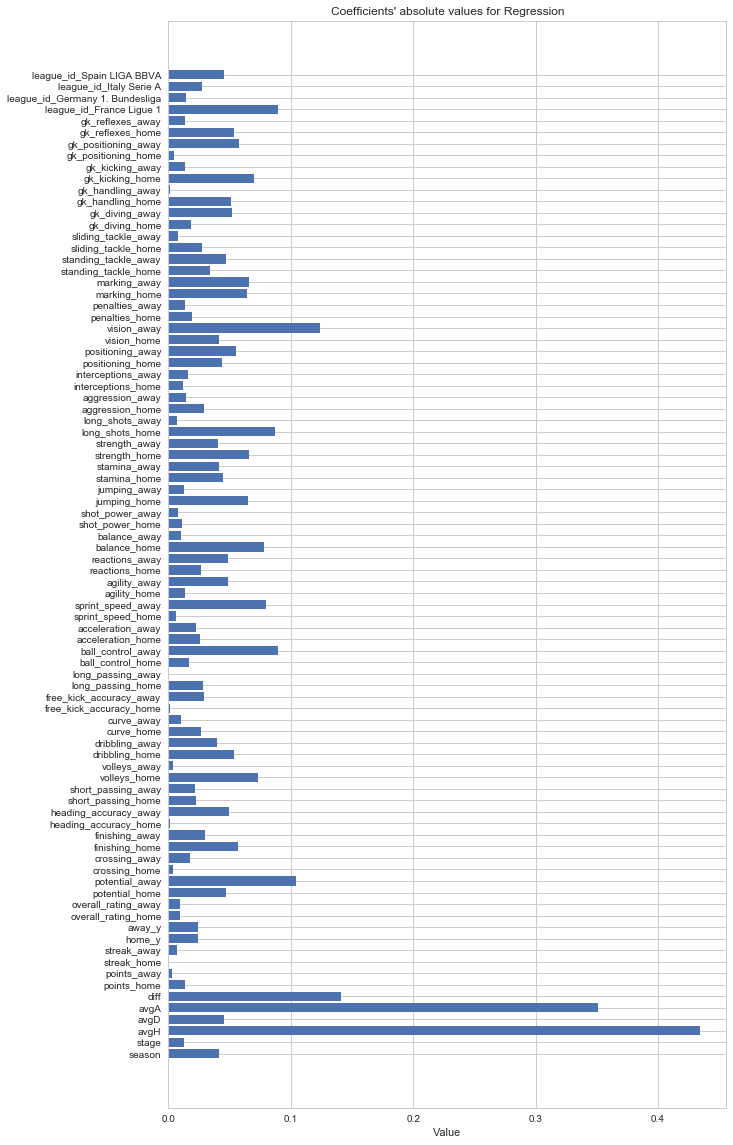

In [212]:
# plot of coefficients values from Classifiers
names=list(XX.columns)
names.remove('outcome')

pos=list(np.arange(len(names))+.5)
val=model.coef_[0]
# val=model.feature_importances_
plt.figure(figsize=(10,20))
plt.barh(pos,abs(val), align='center')
plt.yticks(pos, names)
plt.title('Coefficients\' absolute values for Regression')
plt.xlabel('Value')
# plt.title('Feature Importances values for Random Forest')
# plt.xlabel('Importance')
plt.show()

## Using odds to score classifiers instead of accuracy

In [213]:
# selecting columns with odds data from match_data 
select=[]
for i in range(85,115,3):
    select.append(i)
for i in range(86,115,3):
    select.append(i)
for i in range(87,115,3):
    select.append(i)
len(select)
dfout = match_data.iloc[:,select]

# setting index equal to XX
dfout= dfout[(dfout.index).isin(XX.index)]

# creating avg columns for H, D, and A odds (from betdf) 
for col in avg_lst:
    dfout[col] = betdf[col]
print('match_data',match_data.shape)
print('dfout',dfout.shape)
print('XX',XX.shape)
print('XX_scaled',XX_scaled.shape)
print('betdf',betdf.shape)
print('X',X.shape)
dfout.shape

match_data (14585, 115)
dfout (14577, 33)
XX (14577, 87)
XX_scaled (14577, 86)
betdf (14577, 16)
X (14577, 84)


(14577, 33)

In [222]:
# creating max and min columns for H, D, and A odds
letters = ['H','D','A']
for i,letter in enumerate(letters):
    dfout['max'+letter] = np.nanmax(dfout.iloc[:,(i)*10:(i+1)*10],axis=1)
#     dfout['min'+letter] = np.nanmin(dfout.iloc[:,(i)*10:(i+1)*10],axis=1)
# creating cost column for winning $10 bet    
dfout['gain_for_$10'] = round(100*(10-(10/dfout['maxH']+10/dfout['maxD']+10/dfout['maxA'])),2)
# dfout.sort_values('gain_for_$10')

# building predicted odds from model predicted probabilities
tmp = model.predict_proba(XX_scaled)
tmpdf = pd.DataFrame(tmp)
tmpdf.index = dfout.index
# reordering Home and Away win
swap = tmpdf[0].copy()
tmpdf[0] = tmpdf[2].copy()
tmpdf[2] = swap
# computing odds in dfout
for i,letter in enumerate(letters):
    dfout['prob'+letter] = tmpdf[i]
#     del dfout['pred'+letter]
    dfout['pred'+letter] = round(1/tmpdf[i],2)

# determining theoretical gain of model predictions. That is: if probabilities from model are correct
# for a cost of  10/dfout['maxdH']) + 10/dfout['maxD'] + 10/dfout['maxA'] we will expect to win
# 10/dfout['predH']) + 10/dfout['predD'] + 10/dfout['predA']
dfout['arb gain'] = round(10/dfout['predH'] + 10/dfout['predD'] + 10/dfout['predA']\
                          - 10/dfout['maxH'] - 10/dfout['maxD'] - 10/dfout['maxA'],2)

gainwo = (dfout['gain_for_$10'].sum()/100)
gain = (dfout['arb gain'].sum()/100)
print('Total gain by betting $10 on EACH game without model: ${0:.2f} (investing ${1:.2f} for a ROI of {2:.2f}%)'\
                  .format(gainwo, 10*dfout.shape[0], 100*(gainwo/(10*dfout.shape[0]))))
time.sleep(1)
print('Total gain by betting $10 on EACH game with model: ${0:.2f} (investing ${1:.2f} for a ROI of {2:.2f}%)'\
                  .format(gain, 10*dfout.shape[0], 100*(gain/(10*dfout.shape[0]))))

time.sleep(1)
newdf = dfout[dfout['arb gain']>0].sort_values(by='arb gain', ascending=False)
gainpos = (newdf['arb gain'].sum()/100)
print('Total gain by betting $10 on POSITIVE RETURN games with model: ${0:.2f} (investing ${1:.2f} for a ROI of {2:.2f}%)'\
                      .format(gainpos, 10*newdf.shape[0], 100*(gainpos/(10*newdf.shape[0]))))

Total gain by betting $10 on EACH game without model: $-2534.65 (investing $145770.00 for a ROI of -1.74%)
Total gain by betting $10 on EACH game with model: $-25.33 (investing $145770.00 for a ROI of -0.02%)
Total gain by betting $10 on POSITIVE RETURN games with model: $1.17 (investing $14040.00 for a ROI of 0.01%)


In [231]:
dfout.iloc[:,30:].head(2)

,avgH,avgD,avgA,maxH,maxD,maxA,gain_for_$10,probH,predH,probD,predD,probA,predA,arb gain
0,1.278889,4.822222,10.083333,1.30,5.5,12.0,-34.38,0.719398,1.39,0.181150,5.52,0.099451,10.06,-0.34
1,1.208889,5.522222,12.222222,1.25,6.5,15.0,-20.51,0.779482,1.28,0.182001,5.49,0.038517,25.96,-0.19


In [223]:
# determining actual return of model for best {# of} games, 
# Must set min # of games and step size
# results are stored in gd dataframe
mingames=20
maxgames=dfout[dfout['arb gain']>0].shape[0]
step = 50
gameslst=range(mingames,maxgames,step)
gamesdict = {}
for games in gameslst:
    newdf = dfout[dfout['arb gain']>0].sort_values(by='arb gain', ascending=False)[:games]
    gainpos = (newdf['arb gain'].sum()/100)
#     print('Predicted gain by betting $10 on best {0:d} games with model: ${1:.2f} (investing ${2:.2f} for a ROI of {3:.2f}%)'\
#                       .format(games, gainpos, 10*newdf.shape[0], 100*(gainpos/(10*newdf.shape[0]))))
#     time.sleep(1)
    
    # checking predicted strategy with actual outcomes
    newdf['outcome'] = betdf['outcome']
    tmpdict={1:'H',0:'D',-1:'A'}
    total = 0
    newdf['outcome'] = newdf['outcome'].map(tmpdict)
    for ind,row in newdf.iterrows():
        total += ((10-row['arb gain']/100)/row['pred'+row['outcome']])*row['max'+row['outcome']]
    gainbest = total - 10*games
#     print('Actual gain by betting $10 on best {0:d} games with model: ${1:.2f} (investing ${2:.2f} for a ROI of {3:.2f}%)'\
#                       .format(games, gainbest, 10*games, 100*(gainbest/(10*games))))
    gamesdict[games]=[10*games, round(gainpos,2), round(100*(gainpos/(10*newdf.shape[0])),2), \
                      round(gainbest,2), round(100*(gainbest/(10*games)),2)]
gd = pd.DataFrame.from_dict(gamesdict, orient='index')
gd.columns = ['Invested', 'Model return', 'Model ROI', 'Actual return', 'Actual ROI']

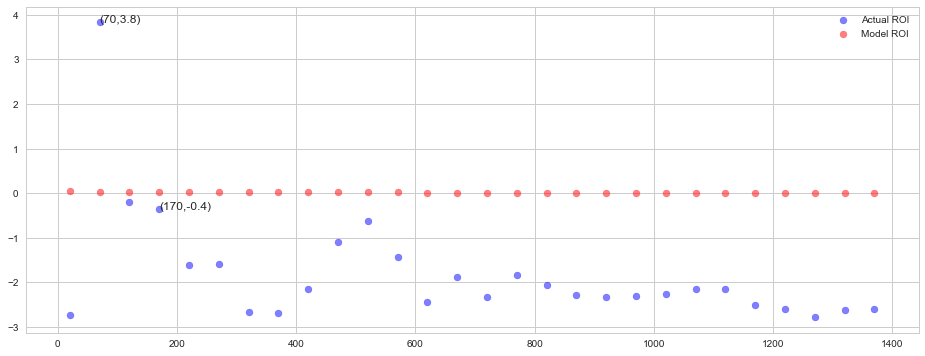

In [224]:
plt.figure(figsize=(16,6))
plt.scatter(list(gd.index),gd['Actual ROI'],c='blue', alpha=.5)  
plt.scatter(list(gd.index),gd['Model ROI'],c='red', alpha=.5) 
for ind,row in (gd[1:5:2]).iterrows():
    plt.text(x=row['Invested']/10, y=row['Actual ROI'], s=str('({0:d},{1:.1f})'.format(int(row['Invested']/10),row['Actual ROI'])))
plt.legend()
plt.show()

In [218]:
newdf.iloc[:,-12:].sort_values(by='arb gain', ascending=False)[:20]

,maxH,maxD,maxA,gain_for_$10,probH,predH,probD,predD,probA,predA,arb gain,outcome
6177,2.10,3.80,5.50,78.83,0.467518,2.14,0.228745,4.37,0.303738,3.29,0.79,A
6172,2.00,3.80,6.25,76.84,0.215567,4.64,0.200243,4.99,0.584190,1.71,0.78,D
7601,7.68,4.80,1.65,55.40,0.363003,2.75,0.333459,3.00,0.303538,3.29,0.56,A
13436,2.38,3.60,3.91,46.30,0.428996,2.33,0.232356,4.30,0.338648,2.95,0.47,H
1803,1.36,6.50,15.00,44.19,0.809855,1.23,0.144725,6.91,0.045420,22.02,0.47,H
7677,2.44,3.75,3.60,45.72,0.432677,2.31,0.287772,3.47,0.279551,3.58,0.46,D
8109,3.36,3.64,2.60,43.04,0.036541,27.37,0.087775,11.39,0.875684,1.14,0.45,D
10856,7.50,3.93,1.75,40.79,0.537655,1.86,0.249097,4.01,0.213249,4.69,0.41,A
13504,1.60,4.92,7.50,38.41,0.063585,15.73,0.068932,14.51,0.867483,1.15,0.40,H
13984,1.60,4.96,7.50,40.05,0.242101,4.13,0.196225,5.10,0.561674,1.78,0.40,A


## Looking into predictions types and accuracy

In [180]:
# Using train data to find best values for modification: limit and eps
# limit is threshold for min(predict_proba) above which we set label = 0
# Idea: if all probabilities are close we predict match is a Draw
ypred_proba=model.predict_proba(Xlr)
limit = np.linspace(0.310,0.325,16)
# eps is subbed from limit to change some home win predictions into draw predictions 
eps = np.linspace(0.000,0.010,11)
mod_rslt = {}
for ep in eps:
    mod_rslt[ep]={}
    for val in limit:
        ymod = ytrain.copy()
        for i,row in enumerate(ypred_proba):
            if min(row) >= val:
                ymod[i] = 0
            elif (min(row) >= val-ep) and (max(row) == row[0]):
                ymod[i] = 0
        mod_rslt[ep][val] = (ymod==ylr).mean()
mod_rsltdf = pd.DataFrame.from_dict(mod_rslt, orient='index')
print('Best model prediction (on training set) is now: {}'.format(mod_rsltdf.max(axis=1).max()))

Best model prediction (on training set) is now: 0.5316502012440542


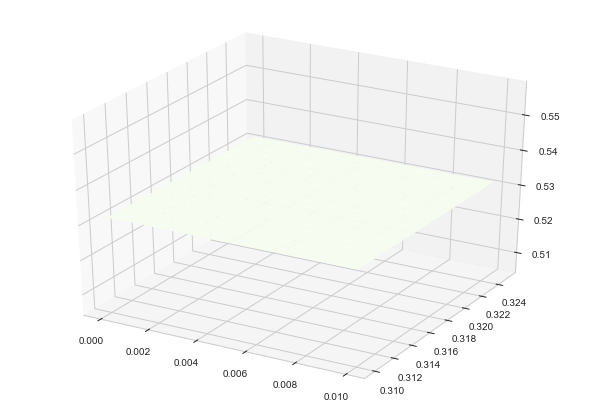

In [181]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
# mod_rsltdf = pd.DataFrame.from_dict(mod_rslt,orient='index')

Xcoord, Ycoord  = np.meshgrid(mod_rsltdf.index, mod_rsltdf.columns.values)
zs = np.array([mod_rsltdf[y][x] for x,y in zip(np.ravel(Xcoord), np.ravel(Ycoord))])
Zcoord = zs.reshape(Xcoord.shape)

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(Xcoord, Ycoord, Zcoord, cmap='GnBu')#, linewidth=0, antialiased=False)  #rstride=1, cstride=1,
plt.show()

In [430]:
indmax = mod_rsltdf.max(axis=1).idxmax(1)
colmax = mod_rsltdf.max(axis=0).idxmax(1)
print('max = ',mod_rsltdf.max(0).max(), 'indmax = ',indmax, 'colmax = ', colmax)
# print((ymod==ytestlr).mean())

max =  0.529309077545 indmax =  0.002 colmax =  0.326666666667


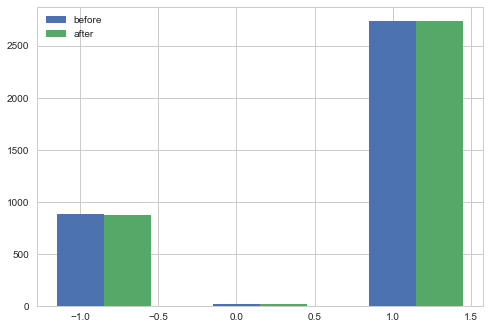

In [432]:
ypred_proba=model.predict_proba(Xtestlr)
ypred_proba.shape
ymod = ytest.copy()
w=.3
# colmax, indmax = .320, .002
xs = np.arange(3)-1
ysb = [list(ytest).count(lab) for lab in xs]
plt.bar(xs,ysb,width=w, label='before')
for i,row in enumerate(ypred_proba):
    if min(row) >= colmax:
        ymod[i] = 0
    elif (min(row) >= colmax-indmax) and (max(row) == row[0]):
        ymod[i] = 1
ysa = [list(ymod).count(lab) for lab in xs]
plt.bar(xs+w,ysa,width=w, label='after')
plt.legend()
plt.show()

In [433]:
# checking what type of predictions (H-D-A) are made in test set
labels = [1,0,-1]
rslts = ['HOME WIN','DRAW','AWAY WIN']

for label,res in zip(labels,rslts):
    Xcheck = XX[XX['outcome']==label]
    pred = ytest[ytest==label].shape[0] # ytrain[ytrain==label].shape[0]+
    print('{0} is the result of {1:.2f}% of the games'.format(res, 100*Xcheck.shape[0]/X.shape[0]), 
          'and is predicted {0:.2f}% of the times.'.format(100*pred/Xtestlr.shape[0]))
    # checking modified vector
    predmod = ymod[ymod==label].shape[0] # ytrain[ytrain==label].shape[0]+
    print('{0} is the result of {1:.2f}% of the games'.format(res, 100*Xcheck.shape[0]/X.shape[0]), 
          'and after modifying is predicted {0:.2f}% of the times.'.format(100*predmod/Xtestlr.shape[0]))
   
# checking how many predictions are correct by predicted outcome in test set
for label,res in zip(labels,rslts):
    pred = ((ytestlr==ytest) & (ytest == label)).sum() / (ytest == label).sum()
    print('\nThere were {} {} predictions.'.format((ytest == label).sum(), res))
    print('{0} predictions are correct {1:.2f}% of the times.'.format(res, 100*pred)) 
    # checking as well with modified values
    predmod = ((ytestlr==ymod) & (ymod == label)).sum() / (ymod == label).sum()
    print('\nAfter modifying there were {} {} predictions.'.format((ymod == label).sum(), res))
    print('{0} predictions are correct {1:.2f}% of the times.'.format(res, 100*predmod)) 
    
print('\nBefore modifying model score was {}'.format((ytestlr == ytest).mean()))
print('After modifying model score was {}'.format((ytestlr == ymod).mean()))

HOME WIN is the result of 46.33% of the games and is predicted 75.41% of the times.
HOME WIN is the result of 46.33% of the games and after modifying is predicted 75.39% of the times.
DRAW is the result of 25.62% of the games and is predicted 0.39% of the times.
DRAW is the result of 25.62% of the games and after modifying is predicted 0.61% of the times.
AWAY WIN is the result of 28.05% of the games and is predicted 24.20% of the times.
AWAY WIN is the result of 28.05% of the games and after modifying is predicted 24.01% of the times.

There were 2736 HOME WIN predictions.
HOME WIN predictions are correct 54.68% of the times.

After modifying there were 2735 HOME WIN predictions.
HOME WIN predictions are correct 54.70% of the times.

There were 14 DRAW predictions.
DRAW predictions are correct 28.57% of the times.

After modifying there were 22 DRAW predictions.
DRAW predictions are correct 27.27% of the times.

There were 878 AWAY WIN predictions.
AWAY WIN predictions are correct 50.

## Analyzing Results 

In [ ]:
# computing difference between max and min percentage and stdev of percentages
# ideally higher difference would relate better to ties
for con in cons:
    tmp_diff = res.loc[con,:]['percentage'].max()-res.loc[con,:]['percentage'].min()
    tmp_std = res.loc[con,:]['percentage'].std()
    print('Cons ={0:4.1f}, difference = {1:.4f}, std = {2:.4f}'.format(con, tmp_diff, tmp_std))

# pd.set_option('display.multi_sparse', False)
val = len(cons)
# df = res.unstack(0).iloc[:,:val]  # displays predictions
# df = res.unstack(0).iloc[:,val:2*val]  # displays correct
df = res.unstack(0).iloc[:,2*val:3*val]  # displays percentage
df
# res

df.shape
for col in range(df.shape[1]):
    print( stats.pearsonr(range(df.shape[0]),df.iloc[:,col]))  # df.iloc[:,col],

In [ ]:
# Looking at all matches that ended in a tie to study charcteristics of a tie game, these values will be
# compared to those of XX 
df = XX[XX['outcome']==0]
df.describe()
XX.describe()
(((df.describe()).loc['mean',:]-(XX.describe()).loc['mean',:])/(XX.describe()).loc['std',:]).sort_values()

## Replacing player id with actual name

In [9]:
# # creating dictionary with player_api_id and player_name
# player_dict = pd.Series(player_data['player_name'].values,index=player_data['player_api_id']).to_dict()

# for i in range(11):
#     # replacing player number id with player name
#     home='home_player_'+str(i+1)
#     away='away_player_'+str(i+1)
#     match_data[home] = (match_data[home]).map(player_dict)  
#     match_data[away] = (match_data[away]).map(player_dict) 
# # Using replace is too slow, switched to map
# #     match_data = match_data.replace({home: player_dict});
# #     match_data = match_data.replace({away: player_dict});

## Features building
The space below contains code for features under testing. Once the code works it is moved higher (as function) and the call to it happens in **Building X Dataframe for Prediction** section.

In [19]:
# # Feature *TIE* is used to increase prediction of ties based on five stats most likely
# # to predict a tie. It depends on two constants *con* and *eps*
# # when ready to test selected value: set 'con_start = con_stop' to define XX to be used

# # defining XX dataframe used for Regression
# XX = X.copy() 

# # preparing 'tie' and 'diff' columns for XX dataframe
# XX['tie'] = 0

# # building multiindex res dataframe to store results

# # automating cons and tie values
# diff_weight = 2   # weight for most likely-to-predict-tie feature
# con_start = 0     # set con_start=con_stop to assign
# con_stop = 0       # single value to build XX for calculations
# steps = int(round((con_stop-con_start)/.1,0))+1
# cons = np.linspace(con_start,con_stop,steps)
# ties = range(4+diff_weight)

# # building iterable multiindex and columns' names
# iterables = [cons,ties]
# index = pd.MultiIndex.from_product(iterables, names=['constant', 'tie level'])
# columns = ['predictions','correct','percentage','compared']
# res = pd.DataFrame(columns = columns, index=index)

# # storing values in res
# for con in cons:
#     XX['tie'] = (XX['diff'] < XX['diff'].mean() + con*XX['diff'].std())*diff_weight\
#         + (XX['avgD'] < XX['avgD'].mean() + con*XX['avgD'].std())*1 \
#         + (XX['avgA'] < XX['avgA'].mean() + con*XX['avgA'].std())*1 \
#         + (XX['points_home'] < XX['points_home'].mean() + con*XX['points_home'].std())*1 \
#         + (XX['streak_home'] < XX['streak_home'].mean() + con*XX['streak_home'].std())*1 
#     # storing results given 'tie' level
#     for i in range(4+diff_weight):
#         res.loc[con,i]['predictions'] = XX[XX['tie']==i].shape[0]
#         res.loc[con,i]['correct'] = XX[(XX['tie']==i) & (XX['outcome']==0)].shape[0]
#         if XX[XX['tie']==i].shape[0] != 0:
#             res.loc[con,i]['percentage'] = (XX[(XX['tie']==i) & (XX['outcome']==0)].shape[0]/XX[XX['tie']==i].shape[0])
#             res.loc[con,i]['compared'] = res.loc[con,i]['percentage'] - .2529
#         else:
#             res.loc[con,i]['percentage'] = None
#             res.loc[con,i]['compared'] = None
# # XX.dropna(inplace=True)
# XX.shape

## Code for testing and old versions

In [ ]:
##############################################################
############## old streak_feature function  #############################
# def streak_feature(n):
#     """Adds average points feature up to previous games to dataframe"""
#     df=match_data
#     # sorting by stage (within league and season) to make sure points are computed correctly 
# #     df.sort_values(['league_id','season','stage'], inplace=True) ### not needed as match_data is now sorted and reindexed
    
#     # create new series for df to store streak points 
#     df['streak_home'] = pd.Series()
#     df['streak_away'] = pd.Series()

#     # loop over each row in match_data and assign streak using 'points_home' and 'points_away'
#     for index,match in df.iterrows():
# #         print(match['away_team_api_id'])
#         if match['stage'] < n+2:
#             df['streak_home'][index] = df['points_home'][index]; 
#             df['streak_away'][index] = df['points_away'][index]; 
#         else:
#             stage=match['stage']
#             # computations for home team of 'match' game
#             tmp_stage = stage
#             assigned = False
#             while (tmp_stage-n>0) & (not assigned):
#                 subdf = df[(df['season']==match['season']) & (df['stage']==(tmp_stage-n)) & \
#                         ((df['home_team_api_id']==match['home_team_api_id']) | (df['away_team_api_id']==match['home_team_api_id']))]
#                 if subdf.shape[0] != 0:
#                     assigned = True
#                 else:
#                     tmp_stage -= 1
#             if not assigned:
#                 df['streak_home'][index] = df['points_home'][index]
#             else:
#                 if subdf.iloc[0]['home_team_api_id']==match['home_team_api_id']:
#                     df['streak_home'][index] = (match['points_home']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
#                 else:
#                     df['streak_home'][index] = (match['points_home']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
            
#             # computations for away team of 'match' game
#             tmp_stage = stage
#             assigned = False
#             while (tmp_stage-n>0) & (not assigned):
#                 subdf = df[(df['season']==match['season']) & (df['stage']==(tmp_stage-n)) & \
#                         ((df['home_team_api_id']==match['away_team_api_id']) | (df['away_team_api_id']==match['away_team_api_id']))]
#                 if subdf.shape[0] != 0:
#                     assigned = True
#                 else:
#                     tmp_stage -= 1
#             if not assigned:
#                 df['streak_away'][index] = df['points_away'][index]
#             else:        
#                 if subdf.iloc[0]['home_team_api_id']==match['away_team_api_id']:
#                     df['streak_away'][index] = (match['points_away']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
#                 else:
#                     df['streak_away'][index] = (match['points_away']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
    
#     return df['streak_home'], df['streak_away']

In [ ]:
# # Using C=1, identifying best class weights by fitting on full training
# # weights=np.linspace(0.1,.5,21)
# # result=dict()

# # for weight in weights:
# new_model = LogisticRegression(C=1, solver='sag', multi_class = 'multinomial', max_iter=100)# class_weight={1:weight,0:.2,-1:.1})
# new_model.fit(Xlr,ylr)

#     # computing accuracy on train and test sets
# ytrain = new_model.predict(Xlr)
# ytest = new_model.predict(Xtestlr)
    
# print('Training set score: {0:.2f}%'.format(100*accuracy_score(ytrain,ylr)))
# print('Test set score: {0:.2f}%'.format(100*accuracy_score(ytest,ytestlr)))

# # result[weight] = [100*accuracy_score(ytrain,ylr),100*accuracy_score(ytest,ytestlr)]
# # result

In [3]:
# #############################################################################
# # working functions copy of code SLOW

# def find_previous(df,team,season,stage):
#     """Determine previous match given season, stage, and team name
#        Note: stage must be greater or equal to 2"""
# # returning one-row dataframe matching season, stage-1, and either home or away team
#     tmp_stage = stage
#     assigned = False
#     # look for previous match, going back all the way to first game
#     while (tmp_stage >= 2) & (not assigned):
#         previous = df[(df['season']==season) & (df['stage']==tmp_stage-1) & ((df['home_team_api_id']==team) | (df['away_team_api_id']==team))]
#         if previous.shape[0] == 1:
#             assigned = True
#         else:
#             tmp_stage -= 1
    
#     # check if previous game was found, if not (went back to first game!) use current game and set points to 0
#     if not assigned:
#         previous = df[(df['season']==season) & (df['stage']==stage) & ((df['home_team_api_id']==team) | (df['away_team_api_id']==team))]
#         previous.iloc[0]['points_home'] = 0
#         previous.iloc[0]['points_away'] = 0
#     #  establish field of previous game
#     if previous.iloc[0]['home_team_api_id'] == team:
#         field = 'home'
#     else:
#         field = 'away'
#     return previous, field        

    
# def get_points(df, match, field):
#     """Given full dataframe, match data and field of team in current match computes previous points for current match and team"""
#     previous_match, previous_field = find_previous(df, match[field+'_team_api_id'], match['season'], match['stage'])
#     mydict = {'home':0, 'away':1}
#     avg_points = ((match['stage']-2)*previous_match['points_'+previous_field].item() + points_dict[previous_match['outcome'].item()][mydict[previous_field]])/(match['stage']-1)  #   
#     return avg_points

# def points_feature(df):
#     """Adds average points feature up to previous games to dataframe"""
#     # sorting by stage (within league and season) to make sure points are computed correctly
#     df.sort_values(['league_id','season','stage'], inplace=True)
#     # drop rows with 'any' missing values
# #     df.dropna(how='any')
    
#     # (create new) series for df to store average points 
#     df['points_home'] = pd.Series()
#     df['points_away'] = pd.Series()

#     # loop over each row in match_data and assign points using add_points function
#     for index,match in df.iterrows():
#         if match['stage'] == 1:
#             df['points_home'][index] = 0; 
#             df['points_away'][index] = 0; 
#         else:
#             df['points_home'][index] = get_points(df, match, 'home') 
#             df['points_away'][index] = get_points(df, match, 'away')
    
#     return df['points_home'], df['points_away']

# def streak_feature(df,n):
#     """Adds average points feature up to previous games to dataframe"""
#     # sorting by stage (within league and season) to make sure points are computed correctly
# #     df.sort_values(['league_id','season','stage'], inplace=True)
    
#     # create new series for df to store streak points 
#     df['streak_home'] = pd.Series()
#     df['streak_away'] = pd.Series()

#     # loop over each row in match_data and assign streak using 'points_home' and 'points_away'
#     for index,match in df.iterrows():
# #         print(match['away_team_api_id'])
#         if match['stage'] < n+2:
#             df['streak_home'][index] = df['points_home'][index]; 
#             df['streak_away'][index] = df['points_away'][index]; 
#         else:
#             stage=match['stage']
#             # computations for home team of 'match' game
#             tmp_stage = stage
#             assigned = False
#             while (tmp_stage-n>0) & (not assigned):
#                 subdf = df[(df['season']==match['season']) & (df['stage']==(tmp_stage-n)) & \
#                         ((df['home_team_api_id']==match['home_team_api_id']) | (df['away_team_api_id']==match['home_team_api_id']))]
#                 if subdf.shape[0] != 0:
#                     assigned = True
#                 else:
#                     tmp_stage -= 1
#             if not assigned:
#                 df['streak_home'][index] = df['points_home'][index]
#             else:
#                 if subdf.iloc[0]['home_team_api_id']==match['home_team_api_id']:
#                     df['streak_home'][index] = (match['points_home']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
#                 else:
#                     df['streak_home'][index] = (match['points_home']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
            
#             # computations for away team of 'match' game
#             tmp_stage = stage
#             assigned = False
#             while (tmp_stage-n>0) & (not assigned):
#                 subdf = df[(df['season']==match['season']) & (df['stage']==(tmp_stage-n)) & \
#                         ((df['home_team_api_id']==match['away_team_api_id']) | (df['away_team_api_id']==match['away_team_api_id']))]
#                 if subdf.shape[0] != 0:
#                     assigned = True
#                 else:
#                     tmp_stage -= 1
#             if not assigned:
#                 df['streak_away'][index] = df['points_away'][index]
#             else:        
#                 if subdf.iloc[0]['home_team_api_id']==match['away_team_api_id']:
#                     df['streak_away'][index] = (match['points_away']*(stage-1) - subdf.iloc[0]['points_home']*(tmp_stage-1-n))/n
#                 else:
#                     df['streak_away'][index] = (match['points_away']*(stage-1) - subdf.iloc[0]['points_away']*(tmp_stage-1-n))/n
    
#     return df['streak_home'], df['streak_away']